In [9]:




















import numpy as np
import pandas as pd
import seaborn  as sns
import matplotlib.pyplot as plt
np.random.seed(sum(map(ord, "aesthetics")))
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import scale
import scipy as sc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import scale
import os


def parse_response(str_id):
    if str_id.split('_')[1] == 'resp':
        return 1
    return 0
   
    
def preprocess_dataset(dataset):
    gen_names = dataset["SYMBOL"].as_matrix()
    responses = np.zeros(dataset.shape[1]-1, dtype=np.int)
    target_ids = dataset.columns[1:].values
    feature_matrix = np.zeros((dataset.shape[1]-1, dataset.shape[0]), dtype=np.float)
    for idx, target_id in enumerate(target_ids):
        feature_matrix[idx, :] = dataset[target_id].values
        responses[idx] = parse_response(target_id)
    return feature_matrix, responses, target_ids, gen_names


def get_gen_hists(xpression, cl_masks, bins=10):
    xpr_range = (xpression.min(), xpression.max())
    hists = []
    for mask in cl_masks:
        hist, _ = np.histogram(xpression[mask], bins=bins, range=xpr_range)
        hists.append(hist)
    return hists


def get_pdf_sim(p, q):
    return -q.dot(np.log2(p)) - p.dot(np.log2(q))
    # return sc.stats.entropy(p, q)

    
def xpressions_to_order_matrix(xpressions):
    orders_num = np.arange(xpressions.shape[1], dtype=np.int32)
    order_matrix = np.zeros_like(xpressions, dtype=np.int32)
    for row in range(xpressions.shape[0]):
        ordered_ids = np.array([ind 
                          for ind, xpr in sorted([(ind, xpr) 
                                                   for ind, xpr in enumerate(xpressions[row,:])], key=lambda p: p[1])])
        order = np.zeros_like(ordered_ids, dtype=np.int32)
        order[ordered_ids] = np.arange(xpressions.shape[1])
        order_matrix[row, :] = order
    return order_matrix
    
    
def get_relation_matrix(order_seq):
    matrix = np.zeros(shape=(order_seq.shape[0], order_seq.shape[0]), dtype=np.int32)    
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            matrix[row, col] = order_seq[row] - order[col]
    return matrix


def get_relation_cumul_matrix(order_matrix):
    matrix = np.zeros(shape=(order_matrix.shape[1], order_matrix.shape[1]), dtype=np.float32)    
    for row in range(matrix.shape[1]):        
        for col in range(matrix.shape[1]):
            matrix[row, col] = (order_matrix[:, row] - order_matrix[:, col]).mean()
        if row % 1000 == 0:
            print(row)
    return matrix        
# np.histogram(np.array([0,0,0,1,1,2,1]),bins=2, range=(0,1))


def get_pair_value(order_matrix, pair, responses, pr=None):
    if not pr:
        pr = (responses == 1).mean()
        
    p_ab = np.mean(order_matrix[:, pair[0]] > order_matrix[:, pair[1]])
    p_ab_r = np.mean(order_matrix[responses==1, pair[0]] > order_matrix[responses==1, pair[1]])
    pr_ab = (p_ab_r * pr) / p_ab
    
    p_ba = np.mean(order_matrix[:, pair[0]] < order_matrix[:, pair[1]])
    p_ba_r = np.mean(order_matrix[responses==1, pair[0]] < order_matrix[responses==1, pair[1]])
    pr_ba = (p_ba_r * pr) / p_ba
    return pr_ab, pr_ba


def xpression_to_order_feature(xpressions, pairs, gens):
    order_features = np.zeros(shape=(xpressions.shape[0], len(pairs)))
    features_name = []
    for idx, pair in enumerate(pairs):
        order_features[:, idx] = xpressions[:, pair[0]] > xpressions[:, pair[1]] + 0
        features_name.append("compare_expr({}, {})".format(gens[pair[0]], gens[pair[1]]))
    return order_features, features_name
                                            
    

def get_metrics(conf):
    """return tuple (precision 0 class, recall 0 class, precision 1 class, recall 1 class)"""
    prec_0 = conf[0,0]/(conf[1,0] + conf[0,0])
    if (conf[1,0] + conf[0,0]) == 0:
        prec_0 = 0
    recall_0 = conf[0,0]/(conf[0,0] + conf[0,1])
    prec_1 = conf[1,1]/(conf[1,1] + conf[0,1])
    recall_1 = conf[1,1]/(conf[1,1] + conf[1,0])
    if (conf[1,1] + conf[0,1]) == 0:
        prec_1 = 0
    accuracy = (conf[0,0] + conf[1, 1]) / (conf.sum())
    # print(prec_0, recall_0, prec_1, recall_1)
    return prec_0, recall_0, prec_1, recall_1


def get_splits(responses, k=10):
    nonresp = np.arange(responses.shape[0])[responses==0]
    resp = np.arange(responses.shape[0])[responses==1]
    np.random.shuffle(nonresp)
    np.random.shuffle(resp)
    folds = []
    for i in range(9):
        folds.append(np.hstack((resp[i*22:i*22+22],nonresp[i*5:i*5+5])))
    folds.append(np.hstack((resp[9*22:],nonresp[9*5:])))
    cases = []
    for i in range(10):
        test = folds[i]
        train = np.hstack((fold for j, fold in enumerate(folds) if i != j))
        cases.append( (train, test) )                      
    return folds, cases


def do_simmetry_class_cv(X, y, clf, iters=10, cv=10):
    nonresp = np.arange(y.shape[0])[y==0]
    resp = np.arange(y.shape[0])[y==1]
    results_a = []
    results_b = []
    cv_results = []
    accs = []
    # print(nonresp)
    for it in range(iters):
        print("iteration: {}".format(it))
        np.random.shuffle(resp)
        np.random.shuffle(nonresp)
        indicies = np.hstack((nonresp, resp[:nonresp.shape[0]]))
        # print(indicies)
        stat, common_stat, cv_result = do_cross_val(X[indicies, :], 
                     y[indicies],
                     clf, cv)
        results_a.append(stat.mean(axis=0))
        # print(stat.mean(axis=0))
        results_b.append(np.array(common_stat))    
        cv_results.append(cv_result)        
        
    return np.vstack(results_a), np.vstack(results_b), cv_results



def process_results(a, b, cv_results):
    a_aucs = []    
    a_accs = []
    b_aucs = []    
    b_accs = []
    fprs, tprs = [], []
    acts_all = []
    probs_all = []
    for result in cv_results:
        actuals = []
        preds = []
        probs = []
        i = 0
        for actual, predicted, proba in result:
            a_accs.append((actual == predicted).mean())
            actuals.append(actual)
            preds.append(predicted)
            probs.append(proba)
            fpr, tpr, _ = roc_curve(actual, proba)
            a_aucs.append(auc(fpr, tpr))         
        b_accs.append((np.hstack(actuals)==np.hstack(preds)).mean())    
        fpr, tpr, thresh = roc_curve(np.hstack(actuals), np.hstack(probs))
        acts_all.append(np.hstack(actuals))
        probs_all.append(np.hstack(probs))        
        b_aucs.append(auc(fpr, tpr))        
    columns=["precision 0", "recall 0", "precision 1", "recall 1", "accuracy", "auc"]
    rows = ["схема а", "схема б"]    
    data = np.zeros((len(rows), len(columns)))
    data[0, :4] = a.mean(axis=0)
    data[0, 4:] = [np.mean(a_accs), np.mean(a_aucs)]
    data[1, :4] = b.mean(axis=0)
    data[1, 4:] = [np.mean(b_accs), np.mean(b_aucs)]    
    table = pd.DataFrame(data, columns=columns, index=rows)
    fpr, tpr, _ = roc_curve(np.hstack(acts_all), np.hstack(probs_all))    
    plt.plot(fpr, tpr)
    return table


def do_cross_val(X, y, clf,  cv=10):
    skfold = StratifiedKFold(n_splits=cv, shuffle=True)    
    cv_results = []
    # print ((y==1).sum(), (y==0).sum())
    skfold.get_n_splits(X, y)    
    for train, test in skfold.split(X, y):        
        clf.fit(X[train, :], y[train])
        prediction = clf.predict(X[test, :])
        proba = clf.predict_proba(X[test, :])
        cv_results.append((y[test], prediction, proba[:, 1]))
        # print(y[test].shape, (y[test] == 0).sum())        
    conf_m =  confusion_matrix(cv_results[0][0], cv_results[1][0]) * 0
    stat = []    
    fpr_tpr = []
    tpr = []
    accs = []
    for actual, predicted, proba in cv_results:
        conf =  confusion_matrix(actual, predicted)
        stat.append(np.array(get_metrics(conf)))
        conf_m = conf_m + conf        
    # print((conf_m[0, 0] + conf_m[1, 1])/conf_m.sum())    
    return np.vstack(stat), get_metrics(conf_m), cv_results


def get_splits(responses, k=10):
    nonresp = np.arange(responses.shape[0])[responses==0]
    resp = np.arange(responses.shape[0])[responses==1]
    np.random.shuffle(nonresp)
    np.random.shuffle(resp)
    folds = []
    for i in range(9):
        folds.append(np.hstack((resp[i*22:i*22+22],nonresp[i*5:i*5+5])))
    folds.append(np.hstack((resp[9*22:],nonresp[9*5:])))
    cases = []
    for i in range(10):
        test = folds[i]
        train = np.hstack((fold for j, fold in enumerate(folds) if i != j))
        cases.append( (train, test) )                      
    return folds, cases
    
    
def get_n_biggest_sims_ids(sims, subset, n=140):
    subsims = sims[subset]
    bound = np.sort(subsims)[-n]    
    return subset[subsims >= bound][:n]


def read_GEO_dataset(pathto_xpr, pathto_resp, pathto_nonresp, prefix=""):
    geo_dataset = pd.read_csv(os.path.join(prefix, pathto_xpr), sep=" ")    
    with open(os.path.join(prefix, pathto_resp), "r") as respf,\
         open(os.path.join(prefix, pathto_nonresp), "r") as nonrespf:
        resp = set(respf.read().split())
        nonresp = set(nonrespf.read().split())
    responses = np.array(list(map(lambda x: 1 if x in resp else int(x in nonresp) - 1 , geo_dataset.columns[1:])))
    feature_matrix = geo_dataset[geo_dataset.columns[1:]].get_values().T
    target_ids = geo_dataset.columns[1:].values
    gen_names = geo_dataset["Group.1"].as_matrix()
    return feature_matrix, responses, target_ids, gen_names

In [5]:
# columns = ["precision 0", "recall 0", "precision 1", "recall 1", "accuracy", "auc"]
# pd.DataFrame(np.array([0,1,2,3,4,5]).reshape((-1,6)), columns=columns, index=["a"])
process_results(a,b,cv_results)
# np.hstack([cv_results[0][0][0], cv_results[0][0][1]])
# print(a[2,:], "\n", b[2,:])
# conf = np.zeros(shape=(2, 2))
# stats = []
# for actual, predicted, _ in cv_results[2]:
#     conf += confusion_matrix(actual,predicted)
# #   print(confusion_matrix(actual,predicted))
#     # stats.append(get_metrics)
#     print(classification_report(actual,predicted))
#     print(get_metrics(confusion_matrix(actual,predicted)))
# print(conf)
# get_metrics(conf)
# prefix = "."#dataset/breast_cancer_paclitaxel_plus_radiation/
# pathto_xpr = "dataset/breast_cancer_paclitaxel_plus_radiation/GSE22513_expression_by_symbol.txt"
# pathto_resp = "dataset/breast_cancer_paclitaxel_plus_radiation/responders.txt"
# pathto_nonresp = "dataset/breast_cancer_paclitaxel_plus_radiation/nonresponders.txt"

# xpressions2, responses2, target_ids2, gens2 = read_GEO_dataset(pathto_xpr, 
#                                                           pathto_resp,
#                                                           pathto_nonresp,
#                                                           prefix)
# mask = range(0,responses2.shape[0],2)
# xpressions2, responses2, target_ids2 = xpressions2[mask, :], responses2[mask], target_ids2[mask]

NameError: name 'a' is not defined

In [14]:
path_to_dataset = "dataset/GSE20194_breastCancer_TFAC.txt"
dataset = pd.read_csv(path_to_dataset, sep='\t')

In [15]:
xpressions, responses, target_ids, gens = preprocess_dataset(dataset)
# perm = np.arange(xpressions.shape[0])
# np.random.shuffle(perm)
# xpressions = xpressions[perm, :]
# responses = responses[perm]
# target_ids = target_ids[perm]
6/56

0.10714285714285714

In [22]:
# Эвристика 1:
gen_res = []
for g in range(xpressions.shape[1]):
    lg = LogisticRegression(penalty='l1', C=1)
    lg.fit(xpressions[:, g:g+1], responses)
    gen_res.append((lg.predict(xpressions[:, g:g+1]) == responses).mean())

In [27]:
gen_res = np.array(gen_res)
good_h1 = np.arange(gens.shape[0])[gen_res > responses.mean()]
good_h1.shape

(708,)

In [29]:
# Эвристика 2
gen_corr = []
for g in range(xpressions.shape[1]):    
    gen_corr.append(abs(np.corrcoef(xpressions[:, g], responses)[0,1]))
gen_corr = np.array(gen_corr)  
good_h2 = np.arange(gens.shape[0])[gen_corr > np.percentile(gen_corr, 95)]
good_h2.shape

(692,)

In [35]:
# пересечение эвристик 1 2
# interscetion_h1_h2 = np.array([id for id in set(good_h1).intersection(set(good_h2))], dtype=np.int)
interscetion_h1_h2.shape

(281,)

In [36]:
# Эвристика 3
resp_mask = responses == 1
nonresp_mask = responses == 0

gen_pdfs = []
nb_bins = 15
for g in range(xpressions.shape[1]):    
    hists = get_gen_hists(xpressions[:, g], [resp_mask, nonresp_mask], bins=nb_bins)    
    p = (hists[0] + 1) / (hists[0].sum() + hists[0].shape[0]) 
    q = (hists[1] + 1) / (hists[1].sum() + hists[1].shape[0])
    gen_pdfs.append((p, q))
#     gen_pdf_sims.append(get_pdf_sim(p, q))
    if g % 1000 == 0:
         print(g)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [37]:
gen_pdf_sims = []
for gen_pdf in gen_pdfs:
    gen_pdf_sims.append(get_pdf_sim(gen_pdf[0], gen_pdf[1]))    
    #gen_pdf_sims.append(sc.stats.entropy(gen_pdf[0], gen_pdf[1]))    
gen_pdf_sims = np.array(gen_pdf_sims)

In [56]:
good_h3 = get_n_biggest_sims_ids(gen_pdf_sims, np.arange(gens.shape[0]), gen_pdf_sims.shape[0]// 100)
good_h3.shape

(138,)

Рассматривается датасет GSE20194_breastCancer_TFAC, в нем данные по химиотерапии рака молочной железы. В данных два класса: ответчики и неответчики, размер классов 222 и 56 соответственно. В качестве признаков  есть информация по 13832 генам

Вторая итерация:
** мысли:
1. посмотреть на порядок генов
2. надо подумать как можно посчитать похожесть генов, и про перевод в некоторое векторное пространство
3. если удалось перевести какое-то векторное пространство то туже можно подумать про ядра на последовательностях 
   и разные сеточки **
   
##### 1. порядок генов:

После собрания стало известно что использовалась хитрая нормализация (квантильная???), такая что по сути сохранился только порядок экспрессий генов, а сами значения по сути не особо важны. 
Тут думаю стоит посмотреть нет ли какой-либо взаимосвязи между взаимным расположением генов в ряду генов осортированных по уровню экспрессии и ответом на терапию.

Пока в голову пришла только мысль сделать аналог матрицы смежности для генов по группам, где на позиции (i, j) будет стоять усредненная по группе разность в порядковых номере i-го и j-го генов в упорядоченном по возрастанию экспрессии ряду генов.

Усреднение по группам по тому что если делать для каждого отдельно наверно надо оочень много памяти

*Да еще комментарий: если смотреть просто порядковый номер гена, то это видимо будет тоже самое что было с простым использованием экспрессий...*

Далее думаю имеет смысл посмотреть есть есть ли какие-то специфичные группе пары генов по расположению, а еще лучше какие-либо n-граммы.

- посмотрел на пары у которых большая разница в порядковых номерах для ответчиков и неответчиков
- далее решил сделать для генов вывод pr(response==1 | A > B), pr(response==1 | A < B), где A = order_num(gen_a) ... - то есть порядковый номер гена A в последвательности, для B аналогично. Вроде есть интересные моменты например для генов 2 и 1, получилось что вероятность ответа 1 при условии что order_num(ген1) < order_num(ген2)
- а может сразу сроить выводы pr(response==1 | A > B) и pr(response==1 | A < B) вместо матрицы смежности?


In [16]:
order_matrix = xpressions_to_order_matrix(xpressions)
order_matrix.shape

(278, 13832)

In [17]:
value_matrix = np.zeros(shape=(order_matrix.shape[1], order_matrix.shape[1]),  dtype=np.float32)

In [63]:
for i in range(order_matrix.shape[1]):
    for j in range(i+1, order_matrix.shape[1]):
        pr_ab, pr_ba = get_pair_value(order_matrix, (i,j), responses)
        value_matrix[i, j] = pr_ab
        value_matrix[j, i] = pr_ba
    if i % 1000 == 0:
        print("complete: {} rows".format(str(i)))

complete: 0 rows
complete: 1000 rows
complete: 2000 rows
complete: 3000 rows
complete: 4000 rows
complete: 5000 rows
complete: 6000 rows
complete: 7000 rows
complete: 8000 rows
complete: 9000 rows
complete: 10000 rows
complete: 11000 rows
complete: 12000 rows
complete: 13000 rows


In [51]:
np.percentile(value_matrix, 99.)

0.93333333730697632

In [64]:
new_val = value_matrix + 0.
for i in range(order_matrix.shape[1]):
    for j in range(order_matrix.shape[1]):
        if np.isnan(value_matrix[i,j]):
            new_val[i, j] = 0.
            new_val[j, i] = 0.
#             print(i, j)
#             break
           
#         if (value_matrix[i,j]) > a and (value_matrix[i,j] < b):                
#             good_pairs.append((i, j))
        
len(good_pairs)

0

In [119]:
mask = responses == 1
sum(list(order_matrix[mask, 14] < order_matrix[mask, 12549]))
value_matrix[14, 12549], value_matrix[12549, 14]

(0.22222222, 0.81784385)

In [69]:
# val_without_na = value_matrix + 0.0
# val_without_na[np.isnan(value_matrix)] = 0.7986
# dif_matrix[np.isnan(dif_matrix)] = 0
dif_matrix = new_val - new_val.T

In [76]:
# np.save("dif_matrix", dif_matrix)
# diff_old = np.load("dif_matrix.npy")
# np.sum(diff_old == dif_matrix), np.sum(value_matrix == 0

p = np.percentile(dif_matrix, 99.999)#,  np.percentile(diff_old, 99)
np.sum(dif_matrix >= p)
   

0.81318682432174683

In [93]:
# np.isnan(dif_matrix).sum()
# np.isnan(val_without_na).sum()
# good_pairs подбирались по порогам p: 0.820, 0.822, 0.826
good_pairs = []
pairs_val = []
for i in range(order_matrix.shape[1]):
    for j in range(order_matrix.shape[1]):
        if dif_matrix[i, j] > p:       
            pairs_val.append(((i, j), dif_matrix[i, j]))
            # good_pairs.append((i, j))

In [94]:
pairs_val = sorted(pairs_val, key=lambda p_v: -p_v[1])

In [95]:
pairs_val[:70]

[((1930, 2379), 0.83458644),
 ((1744, 7368), 0.83146065),
 ((11804, 7461), 0.83146065),
 ((1421, 7981), 0.82835823),
 ((1422, 7981), 0.82835823),
 ((1423, 7981), 0.82835823),
 ((4149, 2379), 0.82835823),
 ((5256, 2559), 0.82835823),
 ((9760, 5746), 0.82835823),
 ((957, 3302), 0.82527882),
 ((1744, 13569), 0.82527882),
 ((2065, 5803), 0.82527882),
 ((2065, 7560), 0.82527882),
 ((2065, 12247), 0.82527882),
 ((3039, 2379), 0.82527882),
 ((4080, 2559), 0.82527882),
 ((4647, 2559), 0.82527882),
 ((4654, 2559), 0.82527882),
 ((7694, 5746), 0.82527882),
 ((8267, 2559), 0.82527882),
 ((10687, 13393), 0.82527882),
 ((11563, 3197), 0.82527882),
 ((12549, 2379), 0.82527882),
 ((12722, 2559), 0.82527882),
 ((13200, 7073), 0.82527882),
 ((13698, 2559), 0.82527882),
 ((616, 2559), 0.82222223),
 ((705, 2559), 0.82222223),
 ((953, 5555), 0.82222223),
 ((1744, 1131), 0.82222223),
 ((1744, 7564), 0.82222223),
 ((2065, 2552), 0.82222223),
 ((2065, 12524), 0.82222223),
 ((2396, 4148), 0.82222223),
 ((3039

In [415]:
order_features3, pair_names = xpression_to_order_feature(xpressions, good_pairs3, gens)
order_features2, pair_names = xpression_to_order_feature(xpressions, good_pairs2, gens)
order_features1, pair_names = xpression_to_order_feature(xpressions, good_pairs, gens)
order_features1_2, pair_names = xpression_to_order_feature(xpressions,
                                                           [pair for pair in good_pairs
                                                            if (gens[pair[0]] in gens2) and (gens[pair[1]] in gens2)],
                                                           gens)

In [334]:

# symmetr_res_a.mean(axis=0), symmetr_res_b.mean(axis=0)
scaled_xpr  = scale(xpressions)
print(scaled_xpr.mean(axis=0)[1], xpressions.mean(axis=0)[1])
[(gens[pair[0]], gens[pair[1]]) for pair in good_pairs]

-6.62938928373e-17 2145.36807554


[('APBB3', 'CRLF1'),
 ('ARHGAP1', 'CRLF1'),
 ('ATP6V0A1', 'IL12RB2'),
 ('ATP6V0C', 'DUSP14'),
 ('C4A', 'NKTR'),
 ('C4B', 'NKTR'),
 ('C4B_2', 'NKTR'),
 ('CCND1', 'BCOR'),
 ('CCND1', 'MON1B'),
 ('CCND1', 'MTRF1'),
 ('CCND1', 'ZNF165'),
 ('CDK16', 'COCH'),
 ('CERS6', 'CRIPT'),
 ('CERS6', 'JMJD1C'),
 ('CERS6', 'MTO1'),
 ('CERS6', 'TLE1'),
 ('CERS6', 'TOPORS-AS1'),
 ('COL1A1', 'FOLH1B'),
 ('DHCR24', 'COCH'),
 ('DHCR24', 'FOCAD'),
 ('DNASE2', 'GPM6B'),
 ('EIF4B', 'ITGA6'),
 ('ERC1', 'CRLF1'),
 ('FHOD1', 'CRLF1'),
 ('FILIP1L', 'CRLF1'),
 ('FKSG49', 'MFGE8'),
 ('FOLR1', 'COCH'),
 ('GOLGA1', 'CRLF1'),
 ('GON4L', 'CRLF1'),
 ('GP1BA', 'CRLF1'),
 ('HOXB5', 'CRLF1'),
 ('HOXC4', 'FAIM2'),
 ('IGFBP4', 'DEPDC5'),
 ('IGFBP4', 'PIK3CG'),
 ('LYST', 'KCNAB1'),
 ('MIR6831', 'CRLF1'),
 ('MOSPD2', 'CRLF1'),
 ('MXRA8', 'GATA6'),
 ('MYL4', 'CRLF1'),
 ('MZT2B', 'ITGA6'),
 ('NAT1', 'PAQR3'),
 ('NDUFB5', 'MELK'),
 ('NECAB3', 'FBXO11'),
 ('NXPH3', 'CRLF1'),
 ('PEA15', 'NFIB'),
 ('PLXNA3', 'CRLF1'),
 ('PNPO', 'RWDD

In [134]:
rf = RandomForestClassifier(n_estimators=200)
svc = svm.SVC(kernel="linear", C=100)


# full_svc_smtr_a, full_svc_smtr_b = do_simmetry_class_cv(scaled_xpr,
#                                                      responses, svc, iters=10)

# intr_svc_smtr_a, intr_svc_smtr_b = do_simmetry_class_cv(scaled_xpr[:, intersection_gens],
#                                                     responses, svc, iters=10)

# full_rf_smtr_a, full_rf_smtr_b = do_simmetry_class_cv(xpressions,
#                                                      responses, rf, iters=10)

# intr_rf_smtr_a, intr_rf_smtr_b = do_simmetry_class_cv(xpressions[:, intersection_gens],
#                                                      responses, rf, iters=10)

# best31_rf_smtr_a, best31_rf_smtr_b = do_simmetry_class_cv(xpressions[:, best_31],

#                                                      responses, rf, iters=10)
# best31_svc_smtr_a, best31_svc_smtr_b = do_simmetry_class_cv(order_features3, responses,
#                                                             svc, iters=10)

Предообработка

In [331]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
clf = SVC(kernel="linear", probability=True)
xpressions_scaled = scale(xpressions)
# xpressions_scaled
# pro
gens[interscetion_h1_h2]

array(['PDE6C', 'CEP57', 'PDE9A', 'CALU', 'TTK', 'AATF', 'MIR1244-1',
       'MIR1244-2', 'MIR1244-3', 'TMEM109', 'QKI', 'PDIA6', 'PDK1',
       'SNAPC3', 'BACE2', 'NAA50', 'TTYH1', 'EPHB3', 'RPIA', 'SF3B3',
       'GORASP2', 'NUP153', 'NUP155', 'LRRC59', 'PDSS1', 'HLA-G', 'BANK1',
       'ANP32E', 'FOCAD', 'XPNPEP1', 'FOLH1B', 'TUBB4B', 'RAB23', 'EPRS',
       'SUMO3', 'LSM2', 'IQCG', 'NUSAP1', 'NASP', 'CSNK2B', 'ABI1', 'PERP',
       'GPM6B', 'PES1', 'DNAJA1', 'SYK', 'CASP8AP2', 'HN1', 'CHI3L2',
       'ACACA', 'RPL39L', 'TXNDC5', 'BCL11A', 'ISG20', 'SYNRG', 'TYMS',
       'RPP21', 'HNRNPH3', 'RAD1', 'ESPL1', 'CHRM3', 'ITGA6', 'RPS21',
       'ACP1', 'GPR89A', 'GPR89B', 'LCN2', 'CTPS1', 'ITGB4', 'SNRPC',
       'SNRPD1', 'NDC80', 'MAD2L1', 'GPSM2', 'PHACTR2', 'UBE2J1',
       'RALGAPB', 'TAF1D', 'NDRG2', 'TAF5', 'DONSON', 'ITPR3', 'RPS7',
       'TNFAIP8L2-SCNM1', 'RANBP6', 'BLOC1S5-TXNDC5', 'TAP1', 'RAP2A',
       'RRAGD', 'ACTR3', 'ACTR3B', 'HPS5', 'RRM2', 'FZD7', 'SKP2', 'DPY30',


Классификация по всем генам:

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc
схема а,0.775258,0.7620,0.785746,0.763000,0.762500,0.838978
схема б,0.762444,0.7625,0.761922,0.760714,0.761607,0.820966


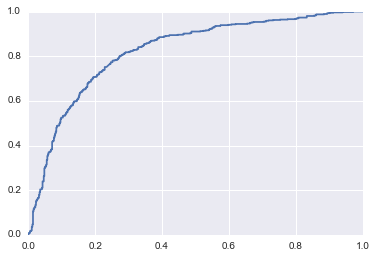

In [391]:
np.random.seed(3267)
a,b, cv_results  = do_simmetry_class_cv(xpressions_scaled, responses, clf)
process_results(a, b, cv_results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc
схема а,0.801714,0.6890,0.744969,0.807000,0.748000,0.799800
схема б,0.782888,0.6875,0.721464,0.807143,0.747321,0.792363


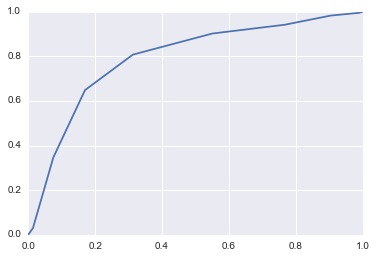

In [392]:
np.random.seed(3267)
knn = KNeighborsClassifier(n_neighbors=8)
a,b, cv_results  = do_simmetry_class_cv(xpressions_scaled, responses, knn)
process_results(a, b, cv_results)

Классификация по пересечению генов из эвристик 1, 2:

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc
схема а,0.815833,0.715333,0.765389,0.828000,0.771667,0.849411
схема б,0.805907,0.716071,0.744806,0.826786,0.771429,0.837404


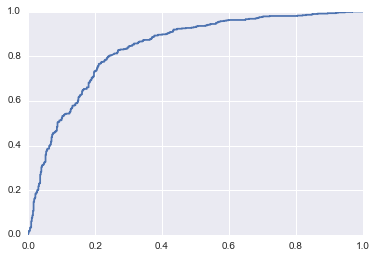

In [431]:
np.random.seed(3267)
a, b, cv_results = do_simmetry_class_cv(xpressions_scaled[:, interscetion_h1_h2], responses, clf)
process_results(a, b, cv_results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc
схема а,0.830000,0.361667,0.616482,0.980000,0.670833,0.861428
схема б,0.949319,0.360714,0.605576,0.980357,0.670536,0.854082


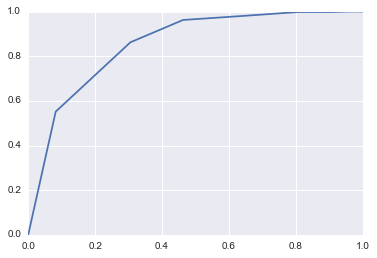

In [430]:
np.random.seed(3267)
knn = KNeighborsClassifier(n_neighbors=8)
a,b, cv_results  = do_simmetry_class_cv(xpressions_scaled[:, interscetion_h1_h2], responses, knn)
process_results(a, b, cv_results)

Классификация по 283 генам, отобранным по эрвистике 3

In [251]:
np.random.seed(3267)
a, b, cv_results = do_simmetry_class_cv(xpressions_scaled[:, good_h3], responses, clf)
process_results(a, b, cv_results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc 0,auc 1
схема а,0.741107,0.706333,0.736232,0.734333,0.720333,0.786744,0.786744
схема б,0.728011,0.703571,0.712430,0.735714,0.719643,0.776961,0.776961


In [321]:
np.random.seed(3267)
knn = KNeighborsClassifier(n_neighbors=8)
a,b, cv_results  = do_simmetry_class_cv(xpressions_scaled[:, good_h3], responses, knn)
process_results(a, b, cv_results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc 0,auc 1
схема а,0.825214,0.683000,0.748078,0.835000,0.759000,0.822400,0.822400
схема б,0.806113,0.682143,0.724832,0.835714,0.758929,0.820249,0.820249


Классификация по пересечению генов из эвристик 1,2,3

In [262]:
intersection_h1_h2_h3 = np.array([ id for id in set(good_h3).intersection(set(interscetion_h1_h2))])

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc
схема а,0.744036,0.690000,0.727667,0.745667,0.717833,0.782478
схема б,0.729178,0.691071,0.706824,0.742857,0.716964,0.768989


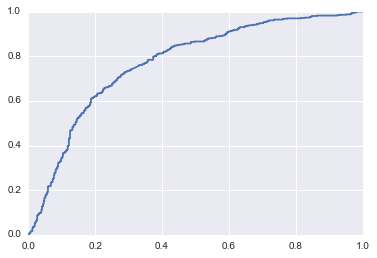

In [427]:
np.random.seed(3267)
a, b, cv_results = do_simmetry_class_cv(xpressions_scaled[:, intersection_h1_h2_h3], responses, clf)
process_results(a, b, cv_results)

In [323]:
np.random.seed(3267)
knn = KNeighborsClassifier(n_neighbors=8)
a,b, cv_results  = do_simmetry_class_cv(xpressions_scaled[:, intersection_h1_h2_h3], responses, knn)
process_results(a, b, cv_results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc 0,auc 1
схема а,0.875143,0.676667,0.754824,0.892667,0.784667,0.842817,0.842817
схема б,0.863888,0.675000,0.733559,0.892857,0.783929,0.838664,0.838664


Классификация по 9 парам из эвристики 4

In [289]:
print(order_features3.shape)
np.random.seed(3267)
a, b, cv_results = do_simmetry_class_cv(order_features3, responses, clf)
process_results(a, b, cv_results)

(278, 9)
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc 0,auc 1
схема а,0.95,0.406333,0.636123,1,0.703167,0.739500,0.739500
схема б,1.00,0.408929,0.628546,1,0.704464,0.696445,0.696445


In [324]:
np.random.seed(3267)
knn = KNeighborsClassifier(n_neighbors=8)
a,b, cv_results  = do_simmetry_class_cv(order_features3, responses, knn)
process_results(a, b, cv_results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc 0,auc 1
схема а,0.5,1,0,0,0.5,0.633333,0.633333
схема б,0.5,1,0,0,0.5,0.633929,0.633929


Классификация по 70 парам из эвристики 4

(278, 70)
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc
схема а,1,0.715667,0.793103,1,0.857833,0.938833
схема б,1,0.717857,0.780151,1,0.858929,0.915099


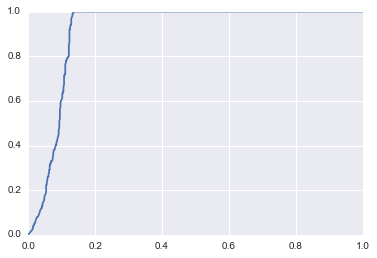

In [417]:
print(order_features1.shape)
np.random.seed(3267)
# a, b, cv_results = do_simmetry_class_cv(order_features1, responses, clf)
a, b, cv_results = do_simmetry_class_cv(order_features1_2, responses, clf)
process_results(a, b, cv_results)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


,precision 0,recall 0,precision 1,recall 1,accuracy,auc
схема а,0.5,1,0,0,0.5,0.762833
схема б,0.5,1,0,0,0.5,0.762500


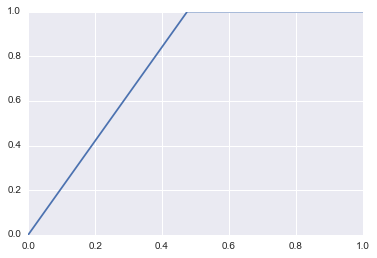

In [423]:
np.random.seed(3267)
knn = KNeighborsClassifier(n_neighbors=2)
a,b, cv_results  = do_simmetry_class_cv(order_features1_2, responses, knn)
process_results(a, b, cv_results)

In [424]:
def get_splits(responses, k=10):
    nonresp = np.arange(responses.shape[0])[responses==0]
    resp = np.arange(responses.shape[0])[responses==1]
    np.random.shuffle(nonresp)
    np.random.shuffle(resp)
    folds = []
    for i in range(9):
        folds.append(np.hstack((resp[i*22:i*22+22],nonresp[i*5:i*5+5])))
    folds.append(np.hstack((resp[9*22:],nonresp[9*5:])))
    cases = []
    for i in range(10):
        test = folds[i]
        train = np.hstack((fold for j, fold in enumerate(folds) if i != j))
        cases.append( (train, test) )                      
    return folds, cases
    

In [425]:
good_pairs_str = [('APBB3', 'CRLF1'), ('ARHGAP1', 'CRLF1'), ('ATP6V0A1', 'IL12RB2'), ('ATP6V0C', 'DUSP14'), ('C4A', 'NKTR'),
              ('C4B', 'NKTR'), ('C4B_2', 'NKTR'), ('CCND1', 'BCOR'), ('CCND1', 'MON1B'), ('CCND1', 'MTRF1'), ('CCND1', 'ZNF165'),
              ('CDK16', 'COCH'), ('CERS6', 'CRIPT'), ('CERS6', 'JMJD1C'), ('CERS6', 'MTO1'), ('CERS6', 'TLE1'),
              ('CERS6', 'TOPORS-AS1'), ('COL1A1', 'FOLH1B'), ('DHCR24', 'COCH'), ('DHCR24', 'FOCAD'), ('DNASE2', 'GPM6B'),
              ('EIF4B', 'ITGA6'), ('ERC1', 'CRLF1'), ('FHOD1', 'CRLF1'), ('FILIP1L', 'CRLF1'), ('FKSG49', 'MFGE8'),
              ('FOLR1', 'COCH'), ('GOLGA1', 'CRLF1'), ('GON4L', 'CRLF1'), ('GP1BA', 'CRLF1'), ('HOXB5', 'CRLF1'),
              ('HOXC4', 'FAIM2'), ('IGFBP4', 'DEPDC5'), ('IGFBP4', 'PIK3CG'), ('LYST', 'KCNAB1'), ('MIR6831', 'CRLF1'),
              ('MOSPD2', 'CRLF1'), ('MXRA8', 'GATA6'), ('MYL4', 'CRLF1'), ('MZT2B', 'ITGA6'), ('NAT1', 'PAQR3'),
              ('NDUFB5', 'MELK'), ('NECAB3', 'FBXO11'), ('NXPH3', 'CRLF1'), ('PEA15', 'NFIB'), ('PLXNA3', 'CRLF1'),
              ('PNPO', 'RWDD3'), ('POLDIP2', 'COCH'), ('PPIE', 'IL12RB2'), ('R3HDM4', 'ITGA6'), ('RALA', 'GPM6B'),
              ('RASA1', 'YES1'), ('RUFY1', 'ITGA6'), ('SEMA3C', 'BCOR'), ('SEMA3C', 'YIPF4'), ('SNORA67', 'ITGA6'),
              ('SPR', 'DNPH1'), ('STAMBP', 'MSH2'), ('SULT1A2', 'MRPS2'), ('THEMIS2', 'CRLF1'), ('TM6SF1', 'ELAVL2'),
              ('TMEM62', 'ETAA1'), ('TNK1', 'FBXO11'), ('TPBG', 'COCH'), ('TPBG', 'WSB1'), ('TRANK1', 'CRLF1'),
              ('TRPM2', 'CRLF1'), ('VPS35', 'MELK'), ('ZDHHC7', 'ITGA6'), ('ZNF510', 'CRLF1')]
gens_list = gens2.tolist()
good_pairs_new = [(gens_list.index(gen1), gens_list.index(gen2)) for gen1, gen2 in good_pairs_str
              if (gen1 in gens_list) and (gen2 in gens_list)]

order_features1_new, pair_names_new = xpression_to_order_feature(xpressions2, good_pairs_new, gens2)
print(order_features1_new.shape, order_features1_2.shape)


(14, 67) (278, 67)


In [426]:
conf_matrix = confusion_matrix(responses2, knn.predict(order_features1_new))
conf_matrix


array([[10,  0],
       [ 4,  0]])

In [ ]:
print(intr_svc_smtr_a.mean(axis=0), intr_svc_smtr_b.mean(axis=0))
print()
# print(best31_svc_smtr_a.mean(axis=0), best31_svc_smtr_b.mean(axis=0))
# prec_0, recall_0, prec_1, recall_1

In [ ]:
print(intr_svc_smtr_a.mean(axis=0), intr_svc_smtr_b.mean(axis=0))
print()
# print(best31_svc_smtr_a.mean(axis=0), best31_svc_smtr_b.mean(axis=0))
# prec_0, recall_0, prec_1, recall_1

array([[ 0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
         1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  0.],
       [ 1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
         0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
         1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
         1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,
         1., 

In [432]:
__name__

'__main__'